<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/New_2_CV_dirichlet_3_Resnet_Temp_Scaling_old_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch.distributions as dist
from mpl_toolkits import mplot3d
from torch.distributions.dirichlet import Dirichlet

from scipy.stats import multivariate_normal
from scipy.stats import norm

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from scipy.stats import multivariate_normal
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     

In [2]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)                                             
cifar_transform =  transforms.Compose(
      [transforms.ToTensor(),
     transforms.Normalize(cifar_mean, cifar_std)])

In [3]:
train_in = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                                        transform=cifar_transform)
test_in = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                                        transform=cifar_transform)
train_out = torchvision.datasets.SVHN('./data', split ='train', download=True,
                                        transform=cifar_transform)
test_out = torchvision.datasets.SVHN('./data', split ='test', download=True,
                                        transform=cifar_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./files/cifar-10-python.tar.gz to ./files/
Files already downloaded and verified


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [4]:
train_out.data = np.vstack(train_out.data).reshape(-1, 32, 32, 3)

In [5]:
train_in.data = torch.from_numpy(train_in.data)
train_out.data = torch.from_numpy(train_out.data)

In [6]:
train_out.targets = torch.tensor(np.ones(len(train_out.labels))*10, dtype=torch.long)
test_out.targets = torch.tensor(np.ones(len(test_out.labels))*10, dtype=torch.long)

train_all = train_in
train_all.data = torch.cat((train_in.data, train_out.data))
train_all.targets = torch.cat((torch.IntTensor(np.array(train_in.targets)), torch.IntTensor(np.array(train_out.targets))))
train_all.data = train_all.data.cpu().detach().numpy()
train_all.targets = train_all.targets.data.cpu().detach().numpy()

In [7]:
train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/CV_Project

/content/drive/My Drive/CV_Project


In [10]:
! python resnet.py

In [11]:
from resnet import *

In [12]:
model = resnet18()

In [13]:
model.load_state_dict(torch.load('resnet18.pt'))

<All keys matched successfully>

In [14]:
def get_resnet_features(data, model):
  
      x = model.conv1(data)
      x = model.bn1(x)
      x = model.relu(x)
      x = model.maxpool(x)

      x = model.layer1(x)
      x = model.layer2(x)
      x = model.layer3(x)
      x = model.layer4(x)

      x = model.avgpool(x)
      x = x.reshape(x.size(0), -1)

      return x

In [15]:
def get_temperatures(targets):
    temperature = targets.clone().cpu().detach()
    temperature = temperature.apply_(lambda x: 1 if (x == 10) else 5)
    return temperature.to(device)

In [16]:
def get_resnet_output(data, model, targets):
  temp = get_temperatures(targets)
  y = model.forward(data)
  try:
      exp_y = temp.unsqueeze(1) * y 
  except:
      exp_y = temp * y
  y = torch.nn.functional.softmax(exp_y, dim = 1)
  return y

In [17]:
model = model.to(device)
model = model.to(torch.float64)

model = model.type(torch.FloatTensor).to(device)

In [18]:


# testdata = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
#                                         transform=cifar_transform)
# testloader = torch.utils.data.DataLoader(testdata, batch_size=32)


In [19]:
# RUN EVAL
# my_model = resnet18()
# my_model.load_state_dict(torch.load('resnet18.pt'))
# model = model.cuda()
# model.eval()
# correct = 0
# total = 0
# for data in testloader:
#     inputs, labels = data
#     inputs, labels = inputs.cuda(), labels.cuda()
#     outputs = model(torch.autograd.Variable(inputs))
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum()

# accuracy = correct / float(total)
# print(accuracy)

In [20]:
# targets is a torch tensor of targets [3,4,5] for 3 in, [10,10,10] for 3 out, [3,10,1] in,out,im
def target_alpha(targets):
  target = targets.cpu().detach().numpy()
  def gen_onehot(category, total_cat=10):
    label = np.ones(total_cat)
    label[category] = 20
    return label
  target_alphas = []
  for i in target:
    if i==10:
      target_alphas.append(torch.tensor(np.ones(10)))
    else:
      target_alphas.append(torch.tensor(gen_onehot(i)))
  return torch.stack(target_alphas).to(device)

In [21]:
# 1 for out, -1 for in
def check_in_out_lambdas(target_alphas):

  alpha_sum = target_alphas.sum(axis = 1)
  alpha_sum = alpha_sum.cpu().detach()
  lambdas =  alpha_sum.apply_(lambda x: 1 if(x==10) else -1)
  return lambdas.to(device)


In [22]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x, tar):
        
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret

In [23]:

augnet_path =  '/content/drive/MyDrive/CV_Project/augnet'
file_name = 'augnet_resnet_temp_scale_old_loss'
from os import truncate

class AugNet(PriorNet):

    def __init__(self, old_preds_dim, feature_dim, target_dim):
        super().__init__()
        self.y_dim = old_preds_dim
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.fc1 = nn.Linear(feature_dim, 1024)   
        self.relu = torch.nn.ReLU()
        self.fc2_1 = nn.Linear(1024, 512) 
        self.fc2_2 = nn.Linear(512,256)
        #self.fc2 = nn.Linear(1024, 256)        
        self.fc3 = nn.Linear(10 + 256, 512) 
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256,64)
        self.fc6 = nn.Linear(64,10)
        #self.fc6 = nn.Linear(128,10)
     
  

    def forward(self, features, y):

      x = self.fc1(features)
      x = self.relu(x)
      x = self.fc2_1(x)
      x = self.relu(x)
      x = self.fc2_2(x)
      x = self.relu(x)
      #x = self.fc3(x)
      # print("x")
      # print(x.shape)
      # print("y")
      # print(y.shape)

      x = self.fc3(torch.cat((x,y), dim = 1) )
      x = self.relu(x)
      x = self.fc4(x)
      x = self.relu(x)
      x = self.fc5(x)
      x = self.relu(x)
      x = self.fc6(x)

      return x


    def predict_alpha(self, x, model, tar):
            x = torch.FloatTensor(x).unsqueeze(0) 
            x = x.to(device)
            x = x.reshape(-1, 3, 32, 32)
            features = get_resnet_features(x, model)
            t = torch.tensor(tar)
            pred_outputs = get_resnet_output(x, model, t)
#           src = torch.Tensor(x).to(device)
            output = torch.exp(self.forward(features, pred_outputs))
            return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet
  
    def fit(self, epoch_num, optimizer, model):
      self.train()
      loss_track = []
      # Shuffle the input
      train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

      for epoch in range(epoch_num):


        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          #print(type(data))
          #print(data.shape)
          #break

          optimizer.zero_grad()
          target = target.to(device)
          data= data.type(torch.FloatTensor).to(device)
          features = get_resnet_features(data,model)
          features = features.detach().requires_grad_(False)
          y = get_resnet_output(data,model,target)
          y = y.detach().requires_grad_(False)

        
        #  # data = data.to(device)
        #   target = target.to(device)
         
        #   #data = data.permute(0,3,1,2)
        #   #data= data.to(torch.float64)
        #   data= data.type(torch.FloatTensor).to(device)
        #   #x =x.unsqueeze(0)
          
        #   features = get_resnet_features(data,model)
        #   features = features.detach().requires_grad_(False)

        #   y = get_resnet_output(data,model)
        #   y = y.detach().requires_grad_(False)
  
          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          out = self.forward(features, y)
          output_alpha = torch.exp(out)
          # residual_alpha = output_alpha + 

          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)
          lambdas = check_in_out_lambdas(target_a)
          sgm_alpha = torch.sigmoid(output_alpha) 


          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2))  + torch.sum(lambdas * torch.mean(sgm_alpha,1))
          loss_total += loss.item()
          loss.backward(retain_graph=True)
          optimizer.step()


        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
        loss_track.append(loss_total)

        if(epoch%4 == 0):
        
          torch.save({
              'epoch': epoch,
              'model_state_dict': self.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_track,
              }, f"{augnet_path}/{file_name+str(epoch)+'.pth'}")
        
      return loss_track
    
    def max_prob(self, x, tar):
        alphas = self.predict_alpha(x, model, tar)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

In [24]:
dpn = AugNet(10,512,10)
dpn.to(device)
optimizer = optim.Adam(dpn.parameters(), lr=0.001)
torch.nn.utils.clip_grad_norm_(dpn.parameters(), 3.0)
losses = dpn.fit(32, optimizer, model)

Train Epoch: 0 	 Loss: 1.111391
Train Epoch: 1 	 Loss: 1.163013
Train Epoch: 2 	 Loss: 0.984102
Train Epoch: 3 	 Loss: 0.990318
Train Epoch: 4 	 Loss: 0.898869
Train Epoch: 5 	 Loss: 0.981071
Train Epoch: 6 	 Loss: 0.843558
Train Epoch: 7 	 Loss: 0.941415
Train Epoch: 8 	 Loss: 0.909171
Train Epoch: 9 	 Loss: 0.901505
Train Epoch: 10 	 Loss: 0.885947
Train Epoch: 11 	 Loss: 0.828286
Train Epoch: 12 	 Loss: 0.802810
Train Epoch: 13 	 Loss: 0.865154
Train Epoch: 14 	 Loss: 0.813745
Train Epoch: 15 	 Loss: 0.855361
Train Epoch: 16 	 Loss: 1.107189
Train Epoch: 17 	 Loss: 0.864045
Train Epoch: 18 	 Loss: 1.132416
Train Epoch: 19 	 Loss: 0.975102
Train Epoch: 20 	 Loss: 0.913216
Train Epoch: 21 	 Loss: 0.905177
Train Epoch: 22 	 Loss: 0.808884
Train Epoch: 23 	 Loss: 0.833331
Train Epoch: 24 	 Loss: 1.316755
Train Epoch: 25 	 Loss: 0.804071
Train Epoch: 26 	 Loss: 1.007887
Train Epoch: 27 	 Loss: 0.819132
Train Epoch: 28 	 Loss: 0.859025
Train Epoch: 29 	 Loss: 0.802604
Train Epoch: 30 	 Lo

In [41]:
dpn_model = torch.load('augnet/augnet_resnet_temp_scale_old_loss12.pth')
dpn.load_state_dict(dpn_model['model_state_dict'])

<All keys matched successfully>

In [42]:
test_in_full = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                                        transform=cifar_transform)
test_out_full = torchvision.datasets.SVHN('./data', split ='test', download=True,
                                        transform=cifar_transform)

Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [43]:
test_out_full.targets = torch.tensor(np.ones(len(test_out_full.labels))*10, dtype=torch.long)

In [44]:
test_in_cut = test_in_full
test_out_cut = test_out_full

In [45]:
test_in_cut.data = test_in_full.data[0:1000]
test_in_cut.targets = test_in_full.targets[0:1000]
test_out_cut.data = test_out_full.data[0:1000]
test_out_cut.targets = test_out_full.labels[0:1000]
test_in = test_in_cut
test_out = test_out_cut

In [46]:
# miscood.py

def uncertainty_score(dpn, test_data, test_targets, metrics):
  dpn.eval()
  score_lst = []
  for i in range(len(test_data)):
    x = test_data[i]
    tar = test_targets[i]
#     print(x.shape)
#     print(tar.shape)
    with torch.no_grad():
      if metrics=='DE':
        score = dpn.diffenrential_entropy(x, tar).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = dpn.mutual_information(x, tar).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = dpn.max_prob(x, tar).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = dpn.entropy(x, tar).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(dpn, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
    tar = test_label[i]
#     x = [x]
    with torch.no_grad():
      pred = dpn.predict_alpha(x, model, tar)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(torch.tensor(test_label[i]), pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data, test_in.targets, metrics)
  test_out_score = uncertainty_score(network, test_out.data, test_out.targets, metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data,
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [47]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

In [48]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.502035,0.475425,0.481894,0.482671
AUPR,0.918199,0.902078,0.925763,0.910394


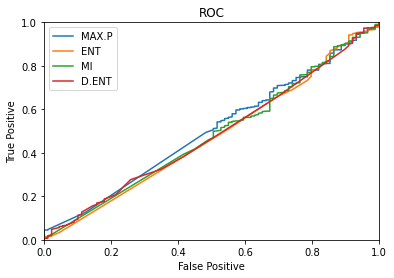

In [49]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

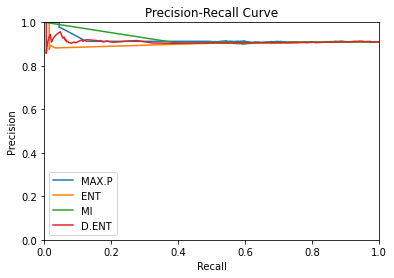

In [50]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

In [51]:
auroc_mp_ood, aupr_mp_ood, label_mp_ood, score_mp_ood = get_test_roc_pr(dpn, 'MAXP', 'ood')
auroc_ent_ood, aupr_ent_ood, label_ent_ood_ood, score_ent_ood = get_test_roc_pr(dpn, 'ENT', 'ood')
auroc_mi_ood, aupr_mi_ood_ood, label_mi_ood, score_mi_ood = get_test_roc_pr(dpn, 'MI', 'ood')
auroc_de_ood, aupr_de_ood, label_de_ood, score_de_ood = get_test_roc_pr(dpn, 'DE', 'ood')

In [52]:
auroc_lst_ood = [auroc_mp_ood, auroc_ent_ood, auroc_mi_ood, auroc_de_ood]
aupr_lst_ood = [aupr_mp_ood, aupr_ent_ood, aupr_mi_ood_ood, aupr_de_ood]

pd.DataFrame(data=np.array([auroc_lst_ood, aupr_lst_ood]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.579226,0.539509,0.552839,0.478120
AUPR,0.563163,0.505302,0.524930,0.472637


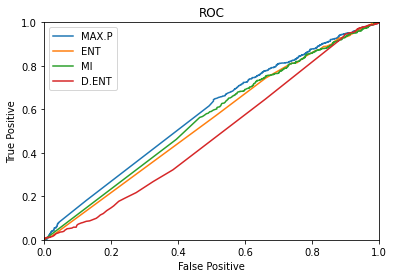

In [53]:
plot_roc(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_roc(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_roc(label_mi_ood, score_mi_ood, label_name='MI')
plot_roc(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

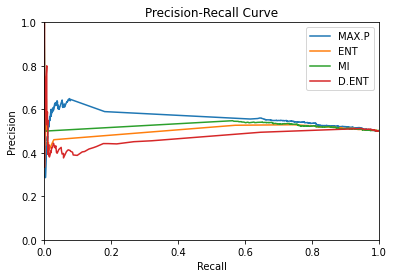

In [54]:
plot_pr(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_pr(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_pr(label_mi_ood, score_mi_ood, label_name='MI')
plot_pr(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

In [ ]:
#dnn = resnet18(PriorNet)

#dnn.load_state_dict(torch.load('resnet18.pt'))
#auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
#auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

#auroc_lst = [auroc_mp, auroc_ent]
#aupr_lst = [aupr_mp, aupr_ent]

#pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
#             columns=['Max.P', 'Ent'], 
#             index=['AUROC', 'AUPR'])

In [ ]:
def get_dnn_maxprob_score(model, data):
   
   Scores = []
   for y in data: 

      x = torch.FloatTensor(y).unsqueeze(0) 
      x = x.to(device)
      x = x.reshape(-1, 3, 32, 32)
      probs = get_resnet_output(x, model)
      #alpha0 = torch.sum(alphas, dim=1, keepdim=True)
      #probs = alphas / alpha0
      conf = torch.max(probs, dim=1)
      Scores.append(conf.values)

   return Scores   
    

In [ ]:
def get_dnn_entropy_score(model, data):

  Scores = []
  for y in data:

      
      x = torch.FloatTensor(y).unsqueeze(0) 
      x = x.to(device)
      x = x.reshape(-1, 3, 32, 32)
      probs = get_resnet_output(x, model) 
      #alpha0 = torch.sum(alphas, dim=1, keepdim=True)
      #probs = alphas / alpha0
      ret = -torch.sum(probs*torch.log(probs), dim=1)
      Scores.append(ret)

  return Scores  


In [ ]:
  
def get_misc_label_score_dnn(dnn, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
    x = torch.FloatTensor(x).unsqueeze(0) 
    x = x.to(device)
    x = x.reshape(-1, 3, 32, 32)
#     x = [x]
    with torch.no_grad():
      pred = get_resnet_output(x, model)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(torch.tensor(test_label[i]), pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

In [ ]:
def resnet_metrics(model, metrics, detect):
   
   if(metrics == 'MAXP'):

       test_in_score = get_dnn_maxprob_score(model, test_in.data)
       test_out_score = get_dnn_maxprob_score(model, test_out.data)  

   
   if(metrics == 'ENT'):

       in_score = get_dnn_entropy_score(model, test_in.data)
       out_score = get_dnn_entropy_score(model, test_out.data) 

   if detect=='ood':
      label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
   elif detect=='misc':
      label_dp, score_dp = get_misc_label_score_dnn(model, test_in.data,
                                                test_in.targets, test_in_score)
   if metrics=='MAXP':
      score_dp = -score_dp

   index = np.isposinf(score_dp)
   score_dp[np.isposinf(score_dp)] = 1e9
   maximum = np.amax(score_dp)
   score_dp[np.isposinf(score_dp)] = maximum + 1
 
   index = np.isneginf(score_dp)
   score_dp[np.isneginf(score_dp)] = -1e9
   minimum = np.amin(score_dp)
   score_dp[np.isneginf(score_dp)] = minimum - 1
 
   score_dp[np.isnan(score_dp)] = 0
 
   auroc, aupr = get_auroc_aupr(label_dp, score_dp)
   return auroc, aupr, label_dp, score_dp     
           
    



In [ ]:
#dnn = resnet18()
#dnn.load_state_dict(torch.load('resnet18.pt'))
#dnn =dnn.to(device)

In [ ]:
#auroc_mp, aupr_mp, _, _ = resnet_metrics(dnn, 'MAXP', 'misc')
#auroc_ent, aupr_ent, _, _ = resnet_metrics(dnn, 'ENT', 'misc')

#auroc_lst = [auroc_mp, auroc_ent]
#aupr_lst = [aupr_mp, aupr_ent]

#pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
#            columns=['Max.P', 'Ent'], 
#            index=['AUROC', 'AUPR'])

In [ ]:
#auroc_mp, aupr_mp, _, _ = resnet_metrics(dnn, 'MAXP', 'ood')
#auroc_ent, aupr_ent, _, _ = resnet_metrics(dnn, 'ENT', 'odd')

#auroc_lst = [auroc_mp, auroc_ent]
#aupr_lst = [aupr_mp, aupr_ent]

#pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
#            columns=['Max.P', 'Ent'], 
#            index=['AUROC', 'AUPR'])

In [ ]:
#test_out